In [54]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.classification import TimeSeriesForest
from pyts.classification import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

In [46]:
df = pd.read_csv('more_ring_data.csv', header=None)
df.columns = ['Board', 'Time', 'Sensor 0', 'Sensor 1', 'Sensor 2', 'Button']
df["Row"] = df.index
board0 = df[df['Board'] == 'Board0']
board1 = df[df['Board'] == 'Board1']
board1['Row'] = board1['Row'] - 1
dfc = pd.merge(board0, board1, on='Row', suffixes=('_0', '_1'))

/tmp/ipykernel_66039/84072449.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  board1['Row'] = board1['Row'] - 1


In [47]:
dfc

,Board_0,Time_0,Sensor 0_0,Sensor 1_0,Sensor 2_0,Button_0,Row,Board_1,Time_1,Sensor 0_1,Sensor 1_1,Sensor 2_1,Button_1
0,Board0,1.161354e+09,1.477588,1.535596,1.515454,0.0,0,Board1,1.150498e+09,1.478394,1.485644,1.500147,0.0
1,Board0,1.161355e+09,1.495312,1.528345,1.503369,0.0,2,Board1,1.150499e+09,1.483227,1.485644,1.499341,0.0
2,Board0,1.161356e+09,1.511426,1.511426,1.492895,0.0,4,Board1,1.150500e+09,1.479199,1.488867,1.502563,0.0
3,Board0,1.161357e+09,1.508203,1.525122,1.500147,0.0,6,Board1,1.150501e+09,1.480811,1.488867,1.504980,0.0
4,Board0,1.162454e+09,1.496924,1.521094,1.500147,0.0,8,Board1,1.151498e+09,1.483227,1.487256,1.500952,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2168,Board0,1.276360e+09,1.504980,1.513037,1.496924,0.0,4336,Board1,1.265405e+09,1.484033,1.492895,1.511426,0.0
2169,Board0,1.276361e+09,1.501758,1.513037,1.497729,0.0,4338,Board1,1.265505e+09,1.480005,1.492090,1.512231,0.0
2170,Board0,1.276460e+09,1.499341,1.519482,1.502563,0.0,4340,Board1,1.265506e+09,1.479199,1.492090,1.509009,0.0
2171,Board0,1.276461e+09,1.500952,1.517065,1.499341,0.0,4342,Board1,1.265605e+09,1.479199,1.493701,1.509814,0.0


In [48]:
X = dfc[['Sensor 0_0', 'Sensor 1_0', 'Sensor 2_0', 'Sensor 0_1', 'Sensor 1_1', 'Sensor 2_1']].to_numpy()
y = dfc['Button_1'].to_numpy()
X.shape, y.shape

((2173, 6), (2173,))

CV 0: 0.8917050691244239
CV 1: 0.7580645161290323
CV 2: 0.6705069124423964
CV 3: 0.7534562211981567
CV 4: 0.6382488479262672
Average score: 0.6944124423963134


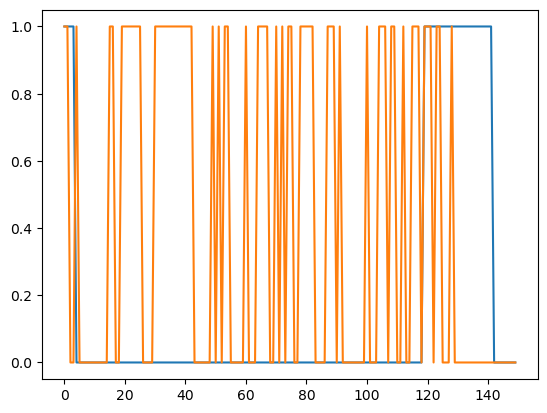

In [49]:
clf = TimeSeriesForest(
    n_estimators=50, criterion='entropy', max_depth=1, n_jobs=-1)

# setup cross validation
cv_num = 5
cv_sz = int(len(X) / cv_num)

avg_score = None

for i in range(cv_num):
    X_test = X[cv_sz * i:cv_sz * (i + 1)]
    y_test = y[cv_sz * i:cv_sz * (i + 1)]
    X_train = np.concatenate((X[:cv_sz * i], X[cv_sz * (i + 1):]))
    y_train = np.concatenate((y[:cv_sz * i], y[cv_sz * (i + 1):]))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"CV {i}: {score}")
    if avg_score is None:
        avg_score = score
    else:
        avg_score = (avg_score + score) / 2

print(f"Average score: {avg_score}")
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)

CV 0: 0.9078341013824884
CV 1: 0.8778801843317973
CV 2: 0.7050691244239631
CV 3: 0.7672811059907834
CV 4: 0.684331797235023
Average score: 0.7337269585253456


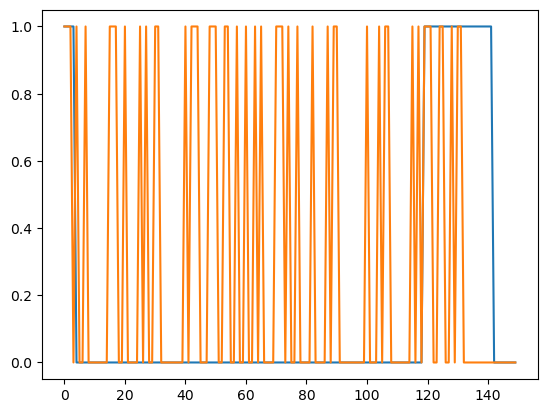

In [50]:
clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

# setup cross validation
cv_num = 5
cv_sz = int(len(X) / cv_num)

avg_score = None

for i in range(cv_num):
    X_test = X[cv_sz * i:cv_sz * (i + 1)]
    y_test = y[cv_sz * i:cv_sz * (i + 1)]
    X_train = np.concatenate((X[:cv_sz * i], X[cv_sz * (i + 1):]))
    y_train = np.concatenate((y[:cv_sz * i], y[cv_sz * (i + 1):]))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"CV {i}: {score}")
    if avg_score is None:
        avg_score = score
    else:
        avg_score = (avg_score + score) / 2

print(f"Average score: {avg_score}")
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)


0.8685139181231811


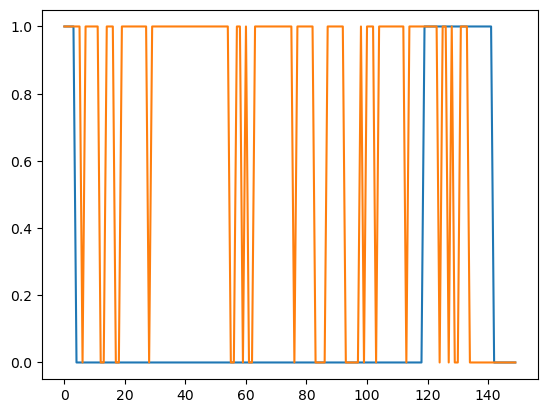

In [58]:
clf=RandomForestClassifier(random_state=42, class_weight="balanced", criterion='gini', max_depth=3, max_features='auto', n_estimators=200)

k_fold = StratifiedKFold(n_splits=cv_num, shuffle=True, random_state=0)

output = cross_validate(clf, X, y, cv=k_fold, scoring='roc_auc', return_estimator=True)
print(output['test_score'].mean())
clf.fit(X, y)

tx = X[-150:]
ty = y[-150:]

pred = clf.predict(tx)
# pred = np.array([1 if pred[i:i+3].sum()/3 > 0 else 0 for i in range(len(pred) - 3)])


plt.plot(ty)
plt.plot(pred)


In [51]:
import pickle

clf.fit(X, y)

with open('model.pkl', 'wb') as f:
    pickle.dump(clf, f)

In [52]:
a = np.array([0,1,2])
b = np.array([1,1,2])
np.vstack([a,b]).shape

(2, 3)